In [2]:
# Import libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# pd.set_option("display.max_rows", None) 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Importing random forest classifier from ensemble module
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve


# Import gradient boosting modules
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import clustering model
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans


<!-- # Predicting Cost of Hospital Stay
## Question: Can we predict the billing amount based on the days a patient will stay in the hospital based on their medical condition, admission types, and treatment details?

- Target Variable: Billing amount <br>
- Modeling Approach: Regression (Linear Regression, Random Forest, XGBoost)<br>
- Hyperparameter Tuning: GridSearchCV or RandomizedSearchCV for tree-based models<br>
- Evaluation Metrics: RMSE, MAE, R² <br>

- Prediciting cost of hospital stay given a particular medical condtion, lenght of stay etc. -->

# Predicting patient's test result
## Question: Can we predict a patient's test result?
- Target Variable: Test Result <br>
- Modeling Approach: Classification (Random Forest Classifier, XGBoost)<br>
- Hyperparameter Tuning: RandomizedSearchCV for tree-based model <br>
- Evaluation Metrics: Accuracy, precision, recall, f1 score <br>


In [3]:
# Load cleaned dataset
df = pd.read_csv('./data/healthcare_dataset_clean.csv')

In [99]:
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Length of Stay
0,bobby jackson,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal,2
1,leslie terry,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive,6
2,danny smith,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal,15
3,andrew watts,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal,30
4,adrienne bell,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal,20


# Feature Engineering

In [5]:
# Length of stay
d1 = pd.to_datetime(df['Date of Admission'])
d2 = pd.to_datetime(df['Discharge Date'])

length_of_stay = (d2-d1)

print(f'Average length of stay: {length_of_stay.mean().days} days')
print(f'Maximum length of stay: {length_of_stay.max().days} days')
print(f'Minimum length of stay: {length_of_stay.min().days} day')

# Add column to dataset
df['Length of Stay']= length_of_stay.dt.days

# Drop original date of admission and discharge to avoid data leakage?

Average length of stay: 15 days
Maximum length of stay: 30 days
Minimum length of stay: 1 day


In [6]:
df_encoded = df.copy()

# Convert billing amount to 2dp
df_encoded['Billing Amount']= df_encoded['Billing Amount'].round(2)

df_encoded.drop(['Name','Doctor', 'Room Number','Hospital',
                 'Date of Admission', 'Discharge Date'],axis=1, inplace=True)
df_encoded.head()

,Age,Gender,Blood Type,Medical Condition,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Length of Stay
0,30,Male,B-,Cancer,Blue Cross,18856.28,Urgent,Paracetamol,Normal,2
1,62,Male,A+,Obesity,Medicare,33643.33,Emergency,Ibuprofen,Inconclusive,6
2,76,Female,A-,Obesity,Aetna,27955.10,Emergency,Aspirin,Normal,15
3,28,Female,O+,Diabetes,Medicare,37909.78,Elective,Ibuprofen,Abnormal,30
4,43,Female,AB+,Cancer,Aetna,14238.32,Urgent,Penicillin,Abnormal,20


In [7]:
# One-hot encode categorical variables
# df_encoded = pd.get_dummies(df_encoded, columns=['Medical Condition', 'Gender', 'Admission Type', 'Test Results'], drop_first=True, dtype=int)

# Label encoding
le=LabelEncoder()
for col in df_encoded.columns:
    if(df_encoded[col].dtype=='object'):
        df_encoded[col]=le.fit_transform(df_encoded[col])

In [8]:
df_encoded.head()

,Age,Gender,Blood Type,Medical Condition,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Length of Stay
0,30,1,5,2,1,18856.28,2,3,2,2
1,62,1,0,5,3,33643.33,1,1,1,6
2,76,0,1,5,0,27955.10,1,0,2,15
3,28,0,6,3,3,37909.78,0,1,0,30
4,43,0,2,2,0,14238.32,2,4,0,20


In [9]:
# Normalise billing amount
scaler = MinMaxScaler()

df_encoded['Billing Amount'] = scaler.fit_transform(df_encoded[['Billing Amount']])

In [10]:
df_encoded.head()

,Age,Gender,Blood Type,Medical Condition,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Length of Stay
0,30,1,5,2,1,0.380933,2,3,2,2
1,62,1,0,5,3,0.650904,1,1,1,6
2,76,0,1,5,0,0.547053,1,0,2,15
3,28,0,6,3,3,0.728798,0,1,0,30
4,43,0,2,2,0,0.296622,2,4,0,20


# Train Random Forest Model


In [28]:
# Train/Test Split
X = df_encoded.drop(columns=['Test Results'])  
y = df_encoded['Test Results']

# y_train = y_train.to_numpy().reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)




In [29]:
# Train model - random forest 
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [90]:
# Predict using test data 
y_pred = rf.predict(X_test)

In [21]:
# Evaluate Performance
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n===== {model_name} Model Evaluation =====")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}\n")
    print(f"\n===== Confusion Matrix: =====\n")
    print(confusion_matrix(y_true, y_pred))
    print(f"\n===== Classification Report:=====\n")
    print(classification_report(y_true, y_pred))

evaluate_model(y_test, y_pred, "Random Forest")


===== Random Forest Model Evaluation =====
Accuracy: 0.3362


===== Confusion Matrix: =====

[[1813 1648 1579]
 [1712 1631 1606]
 [1744 1668 1599]]

===== Classification Report:=====

              precision    recall  f1-score   support

           0       0.34      0.36      0.35      5040
           1       0.33      0.33      0.33      4949
           2       0.33      0.32      0.33      5011

    accuracy                           0.34     15000
   macro avg       0.34      0.34      0.34     15000
weighted avg       0.34      0.34      0.34     15000



## Gini feature importance and visualisation
Provides a measure of how much a feature impurity of a model 

In [22]:
# Finding the important features using the built-in Gini importance
feature_names = X.columns
importances = rf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
feature_imp_df

,Feature,Gini Importance
5,Billing Amount,0.245417
0,Age,0.189308
8,Length of Stay,0.162758
2,Blood Type,0.099435
3,Medical Condition,0.080722
7,Medication,0.071533
4,Insurance Provider,0.069378
6,Admission Type,0.050649
1,Gender,0.030801


Text(0, 0.5, 'Features')

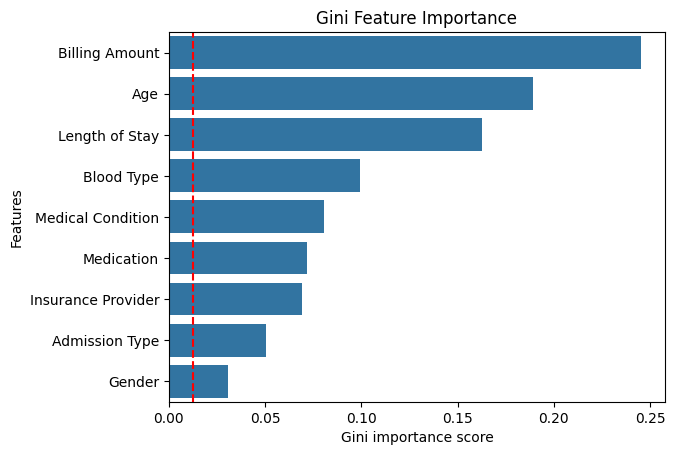

In [23]:
# Threshold for defining which features importance to drop as <5% of the highest score (i.e. Age).
billing_importance = feature_imp_df[feature_imp_df['Feature'] == 'Billing Amount']['Gini Importance'].values[0]
cutoff = billing_importance*0.05

# Bar plot of feature importance
sns.barplot(x=feature_imp_df['Gini Importance'],y=feature_imp_df['Feature'],data=feature_imp_df)
plt.axvline(x=cutoff, color='red', linestyle='--')
plt.title("Gini Feature Importance")
plt.xlabel("Gini importance score")
plt.ylabel("Features")

## Permutation feature importance and visualisation
Measures how much the model's performance degrades when a feature is shuffled i.e. reflects feature's contribution to the predictive power of model. <br>


In [24]:
# Permutation feature importance
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_imp_df = pd.DataFrame({'Feature': feature_names, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)
perm_imp_df

,Feature,Permutation Importance
5,Billing Amount,0.003827
2,Blood Type,0.003673
0,Age,0.002913
8,Length of Stay,0.002787
7,Medication,0.002153
6,Admission Type,0.002080
3,Medical Condition,0.001687
1,Gender,0.001207
4,Insurance Provider,0.000307


Text(0, 0.5, 'Features')

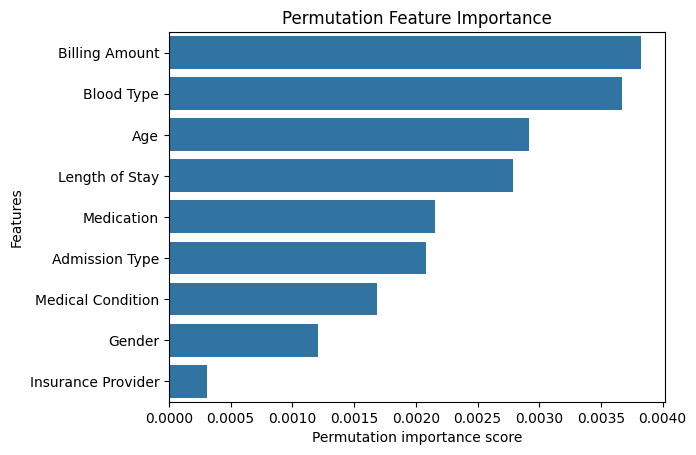

In [25]:
# Creating a seaborn bar plot
sns.barplot(x=perm_imp_df['Permutation Importance'],y=perm_imp_df['Feature'],data=perm_imp_df)
plt.title("Permutation Feature Importance")
plt.xlabel("Permutation importance score")
plt.ylabel("Features")

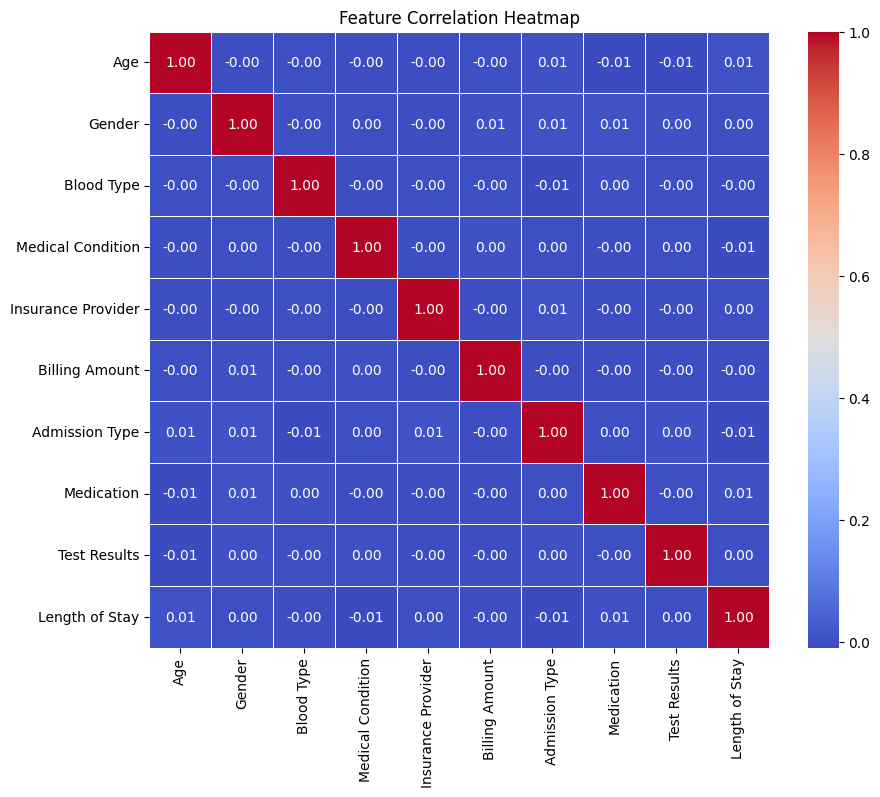

In [26]:
# Compute the correlation matrix
corr_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Heatmap")
plt.show()

Based on above, we will keep all features in the model as there is no clear justification to remove some features.

## Hyperparameter Tuning - Random Forest

In [104]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Define the parameter grid - parameters limited by compute
param_grid = {
    # Number of trees in random forest
    'n_estimators': [25, 50],
    
    # Maximum number of levels in tree
    'max_depth': [5, 10, 20],
    
    # Minimum number of samples required to split an internal node
    'min_samples_split': [2, 5],
    
    # Minimum number of samples required to be at a leaf node
    'min_samples_leaf': [1, 2, 4],
    
    # Method of selecting samples for training each tree
    'bootstrap': [True, False],
    
    # Criterion for measuring quality of split
    'criterion': ['gini', 'entropy']
}


random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings sampled
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=4,  # Use all available cores
    error_score='raise'
)

In [105]:
# Fit Grid search
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [25, 50]},
                   random_state=42, verbose=2)

In [107]:
print("Best parameters:", random_search.best_params_)

Best parameters: {'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}


In [114]:
# Best model
best_rf_model = random_search.best_estimator_

# Feature importance
feature_importance = best_rf_model.feature_importances_
feature_importance

array([0.17683578, 0.02870472, 0.09959178, 0.07965423, 0.07087347,
       0.27798338, 0.04621282, 0.06705825, 0.15308559])

In [111]:
# Train tuned model
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [25, 50]},
                   random_state=42, verbose=2)

In [112]:
# Predict tuned model
tuned_y_pred = best_rf_model.predict(X_test)

In [113]:
# Evaluate tuned model
evaluate_model(y_test, tuned_y_pred, "Tuned Random Forest")



===== Tuned Random Forest Model Evaluation =====
Accuracy: 0.3373


===== Confusion Matrix: =====

[[2106 1476 1458]
 [2045 1483 1421]
 [2081 1460 1470]]

===== Classification Report:=====

              precision    recall  f1-score   support

           0       0.34      0.42      0.37      5040
           1       0.34      0.30      0.32      4949
           2       0.34      0.29      0.31      5011

    accuracy                           0.34     15000
   macro avg       0.34      0.34      0.33     15000
weighted avg       0.34      0.34      0.33     15000



# Gradient Boosting Classifier

In [65]:
# Create DMatrix (optimized data structure for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters
params = {
    'objective': 'multi:softmax',  # Classification task
    'eval_metric': 'mlogloss',             # Use logloss evaluation
    'max_depth': 8,                   # Maximum depth of a tree
    'eta': 0.3,                       # Learning rate
    'seed': 42,                        # Random seed for reproducibility
    'num_class': 3
}

# Train the model
num_boost_round = 100
# model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

# Make predictions
d_pred = model.predict(dtest)


In [66]:
# Evaluate the model
d_pred_labels = np.round(d_pred).astype(int)
evaluate_model(y_test, d_pred_labels, "XGBoost")



===== XGBoost Model Evaluation =====
Accuracy: 0.3333


===== Confusion Matrix: =====

[[1667 1713 1660]
 [1661 1637 1651]
 [1735 1581 1695]]

===== Classification Report:=====

              precision    recall  f1-score   support

           0       0.33      0.33      0.33      5040
           1       0.33      0.33      0.33      4949
           2       0.34      0.34      0.34      5011

    accuracy                           0.33     15000
   macro avg       0.33      0.33      0.33     15000
weighted avg       0.33      0.33      0.33     15000



In [67]:
print(model.get_score(importance_type='weight'))  # Should show features being used


{'Age': 10300.0, 'Gender': 1617.0, 'Blood Type': 5516.0, 'Medical Condition': 4597.0, 'Insurance Provider': 4014.0, 'Billing Amount': 12259.0, 'Admission Type': 2561.0, 'Medication': 4070.0, 'Length of Stay': 8705.0}
